# graph_generator()


## IMPLEMENTACIÓN

  
Esta función se encarga de archivar las observaciones (.csv) importadas desde Netlogo por fecha y hora, a la vez que interpreta los datos de salida gráficamente. 
El procedimiento para su implementación es el siguiente:

1. Ejecutar el modelo en netlogo (uber.nlogo).
2. Al finalizar cada simulación, se deberá ejecutar la función graph_generator() desde este notebook.
3. La función guardara las respectivas graficas en directorios clasificados por fecha y hora, con su respectiva transición(gif).

IMPORTANTE: Al finalizar cada simulación en Netlogo, presione DETENER en la ventana emergente, esto evitara que el programa se siga ejecutando en segundo plano y almacene grandes cantidades de información en el último archivo .csv generado.

In [1]:
from PIL import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from apng import APNG
from IPython.display import Image
from os import walk
import time
import shutil

In [2]:
def graph_generator():
    #CREANDO DIRECTORIOS PARA CADA OBSERVACIÓN 
    fecha = time.strftime('%d-%m-%y')
    hora = time.strftime('%H-%M-%S')
    os.makedirs(str(fecha) +'/'+ str(hora))
    os.makedirs(str(fecha) +'/'+ str(hora)+'/people/gif')
    os.makedirs(str(fecha) +'/'+ str(hora)+'/drivers/gif')
    
    
    #OBTENIENDO LOS CSV´S
    def ls(ruta = '.'):
        return next(walk(ruta))[2]
    outs_files = ls()
    outs_files.pop()
    outs_files
    csvs = [i for i in outs_files if "_.csv" in i]
    csvs
   
    #MOVIENDOLOS A SU RESPECTIVA CARPETA DE OBSERVACIÓN 
    for file in csvs:
        shutil.move(file, str(fecha) +'/'+ str(hora) )
    shutil.move('_GENERAL_.csv', str(fecha) +'/'+ str(hora) )
  
    
    #OBTENIENDO LOS DATOS DE LAS TORTUGAS EN LA NUEVA UBICACIÓN
    def ls1(ruta = str(fecha) +'/'+ str(hora)):
        return next(walk(ruta))[2]
    outs_files1 = ls1()
    outs_files1.pop()
    outs_files1
    csvs1 = [i for i in outs_files if "data_turtles" in i]
    csvs1
    
    #ABRIENDO CSV´S Y FILTRANDO POR 'PEOPLE' Y 'DRIVERS'
            
    for file1 in csvs1:
        d = pd.read_csv(str(fecha) +'/'+ str(hora)+'/'+file1, error_bad_lines=False)
        df = pd.DataFrame(data=d)
        df2 = df[df['breed'] == 'people']
        df3 = df[df['breed'] == 'drivers']
        
     #GENERANDO GRAFICAS Y GUARDANDOLAS EN DIRECTORIO  
        #people
        sns.jointplot(x="x", y="y", data=df2, kind="kde", size=10)
        plt.savefig(plt.savefig(str(fecha) +'/'+ str(hora)+'/people/people' + '_' + str(csvs1.index(file1)+1) + '.png'))
        #drivers 
        sns.jointplot(x="x", y="y", data=df3, kind="kde", size=10)
        plt.savefig(plt.savefig(str(fecha) +'/'+ str(hora)+'/drivers/drivers' + '_' + str(csvs1.index(file1)+1) + '.png'))

#ANIMACIÓN
    
    groups = ['df2','df3']
    for n in groups:
        #people
        if groups[groups.index(n)] == 'df2':

            def ls(ruta = str(fecha) +'/'+ str(hora)+'/people'):

                return next(walk(ruta))[2]

            images_people = ls()
            images_people


            for m in images_people:                           
                img = str(str(fecha) +'/'+ str(hora)+'/people/' + m)       
                img
                graphs = images_people
                graphs[int(images_people.index(m))] = img                        

            APNG.from_files(graphs, delay = 400).save(str(fecha) +'/'+ str(hora)+'/people/gif/trans_p_'+str(fecha) +'_'+ str(hora)+'.png')
            Image(filename = str(fecha) +'/'+ str(hora)+'/people/gif/trans_p_'+str(fecha) +'_'+ str(hora)+'.png')
        #drivers
        elif groups[groups.index(n)] == 'df3':

            def ls(ruta = str(fecha) +'/'+ str(hora)+'/drivers'):

                return next(walk(ruta))[2]

            images_drivers = ls()
            images_drivers


            for x in images_drivers:                           
                immg = str(str(fecha) +'/'+ str(hora)+'/drivers/' + x)       
                immg
                graphs = images_drivers
                graphs[int(images_drivers.index(x))] = immg                        

            APNG.from_files(graphs,delay=400).save(str(fecha) +'/'+ str(hora)+'/drivers/gif/trans_d_'+str(fecha) +'_'+ str(hora)+'.png')
            Image(filename=str(fecha) +'/'+ str(hora)+'/drivers/gif/trans_d_'+str(fecha) +'_'+ str(hora)+'.png')
            
    

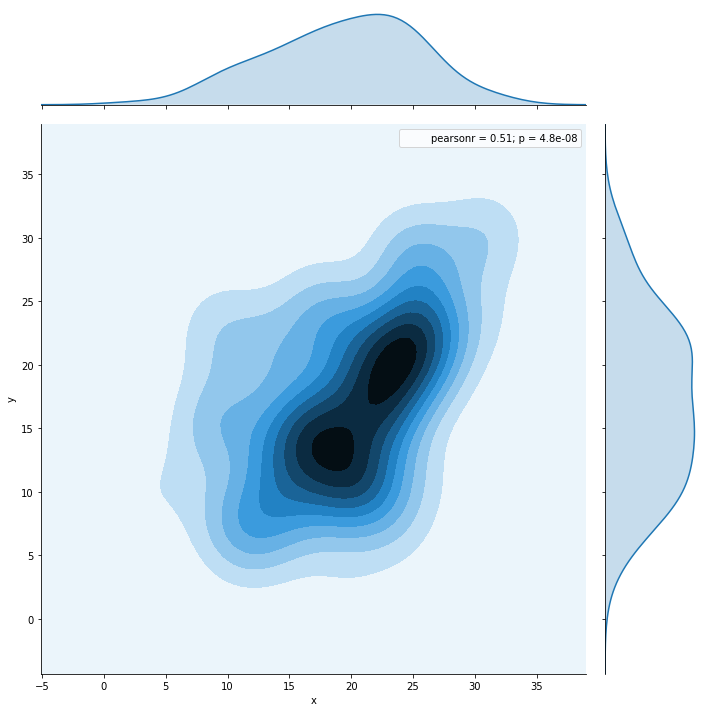

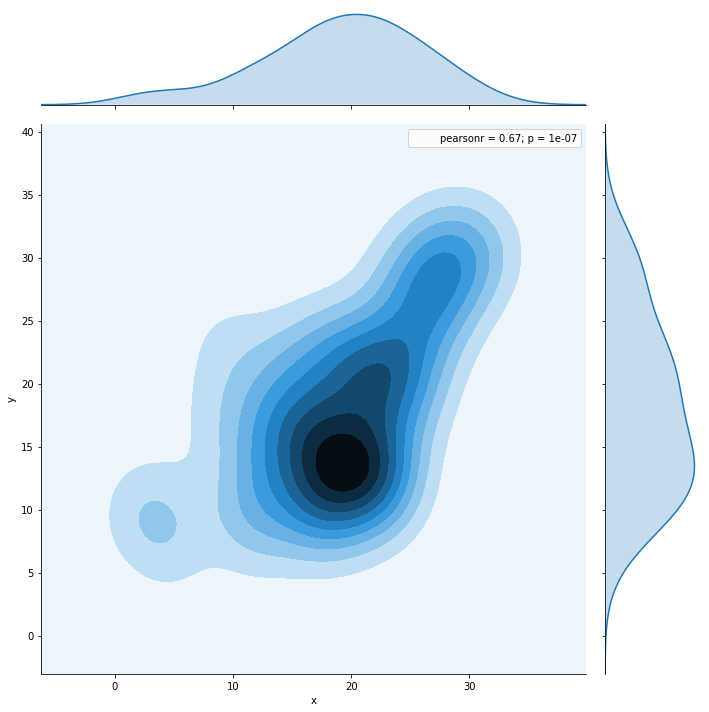

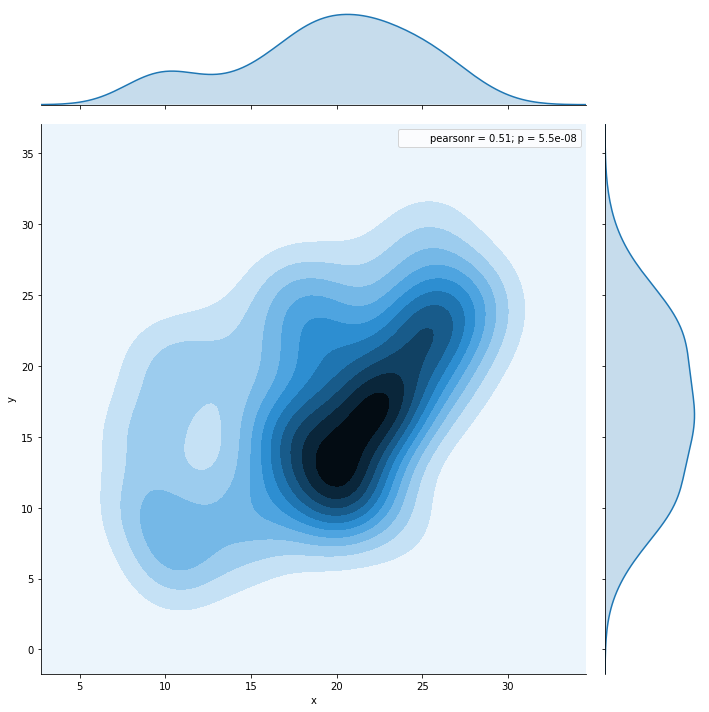

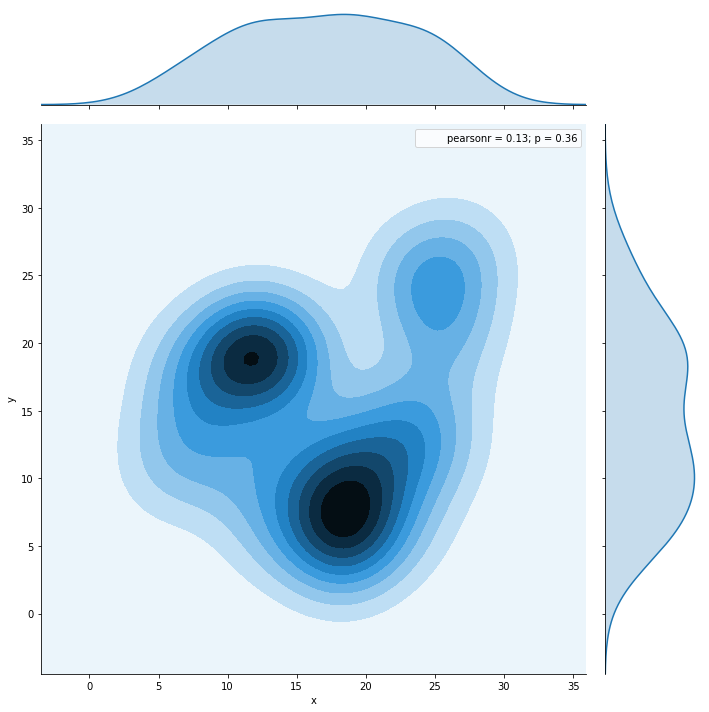

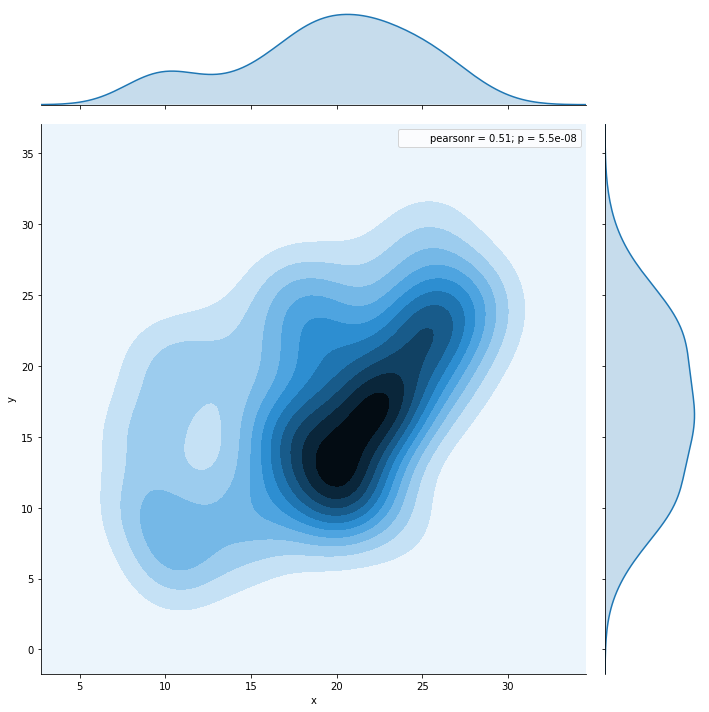

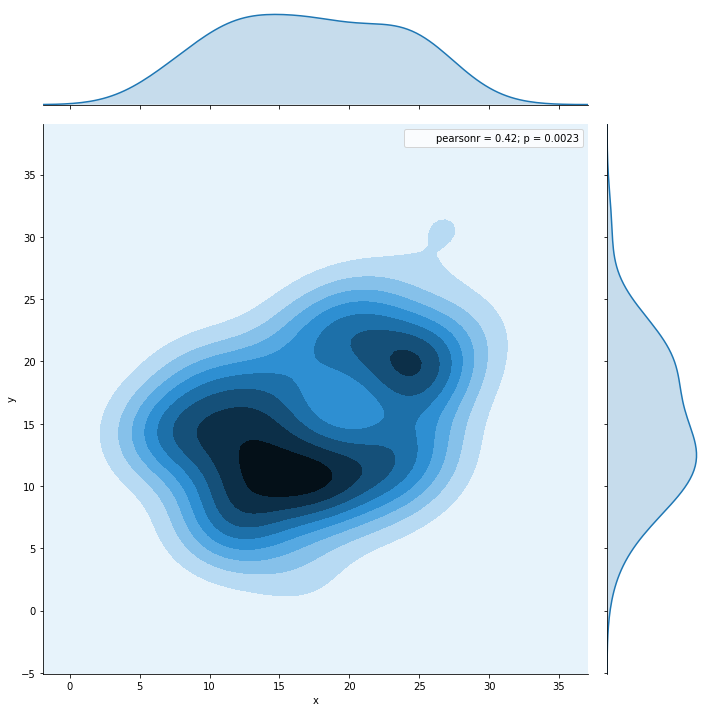

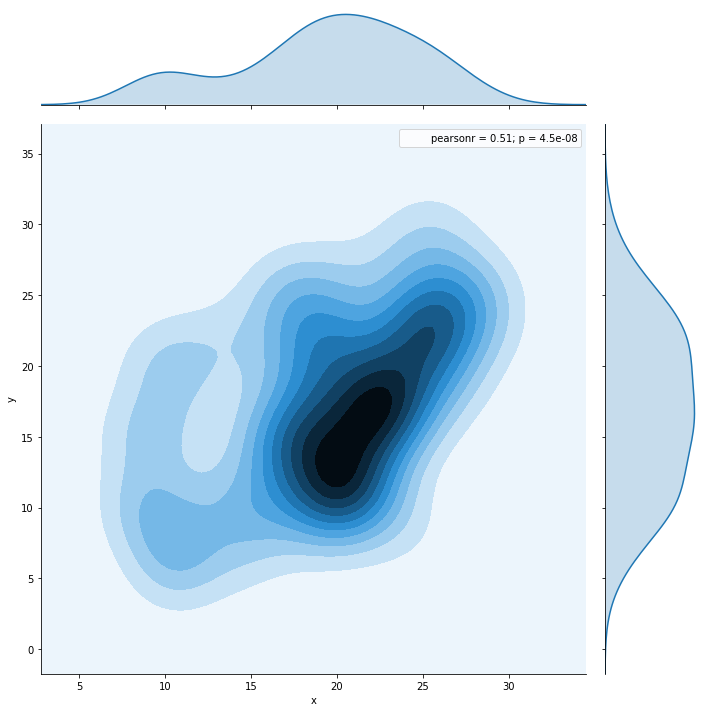

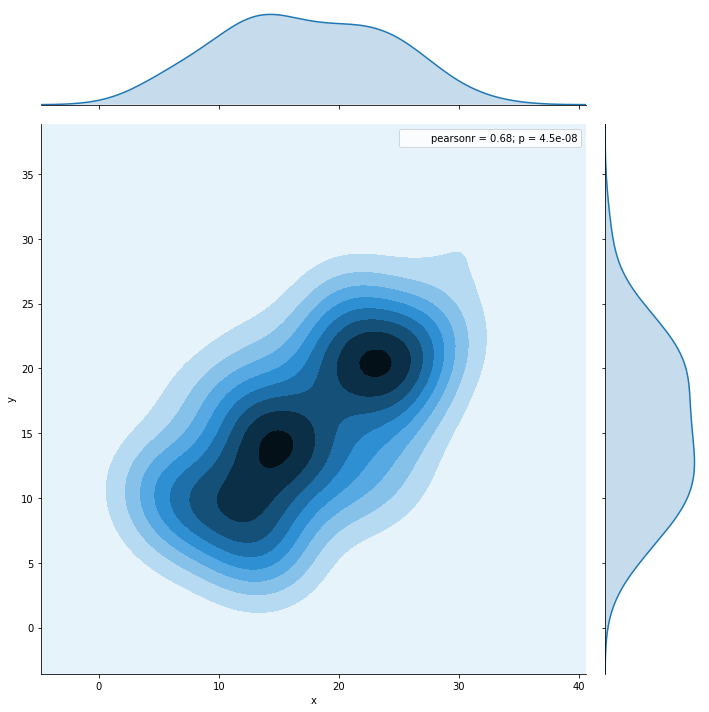

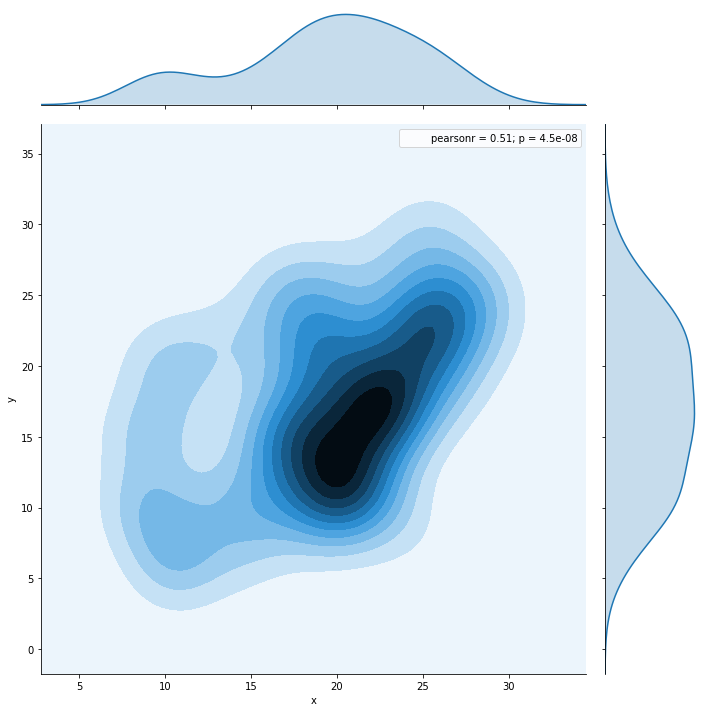

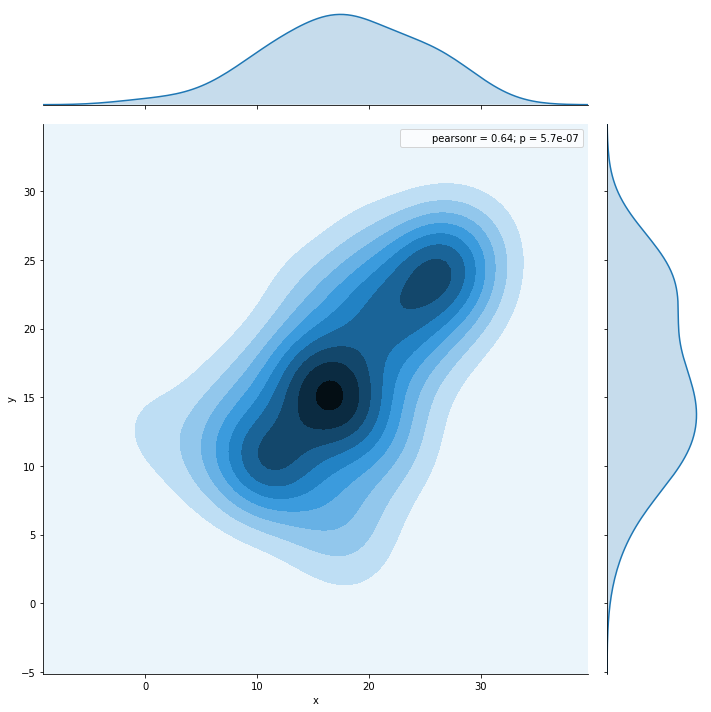

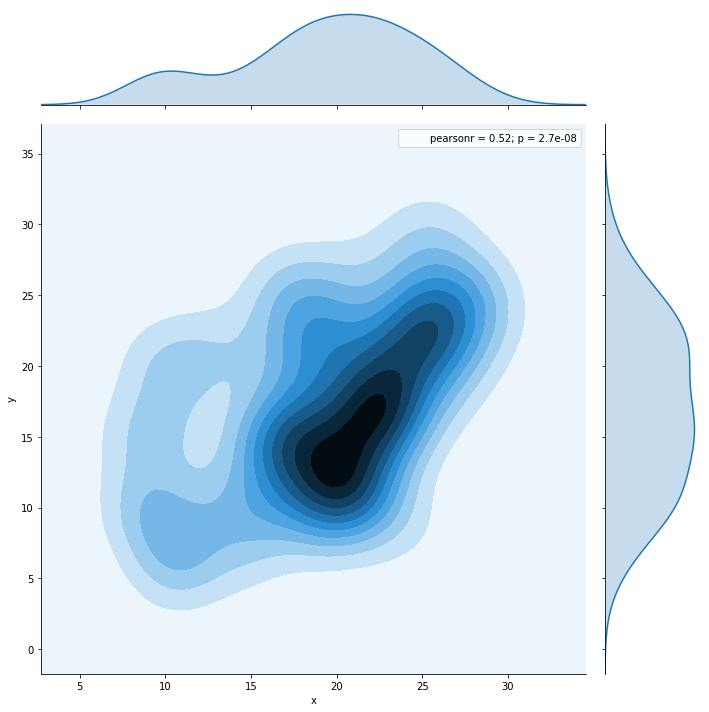

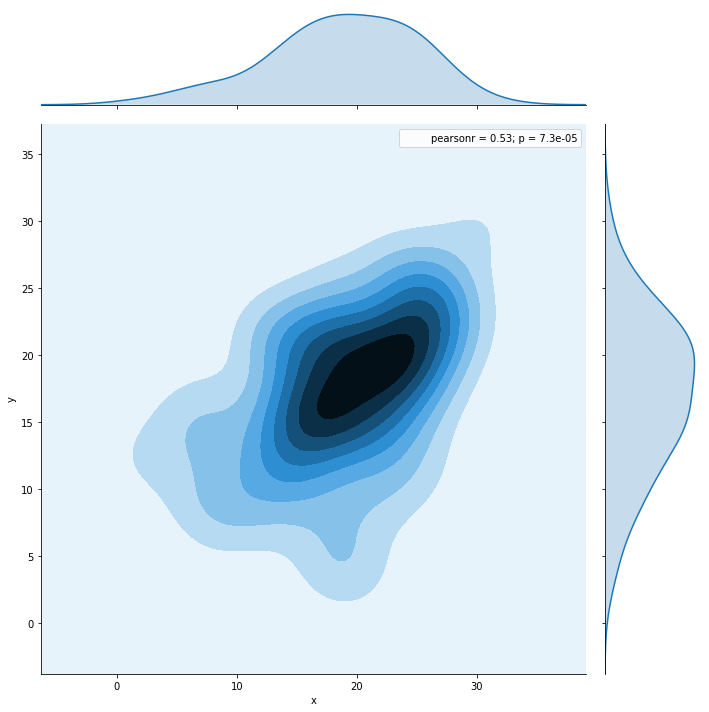

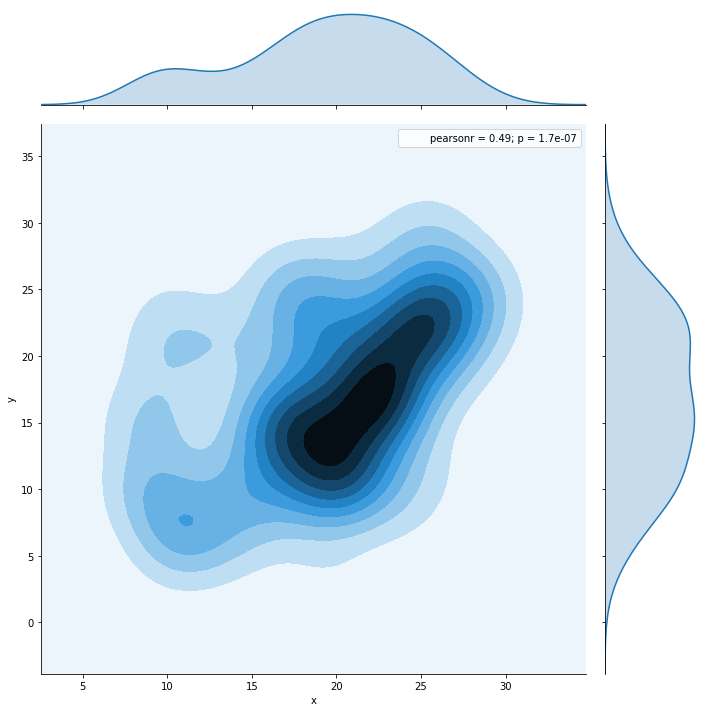

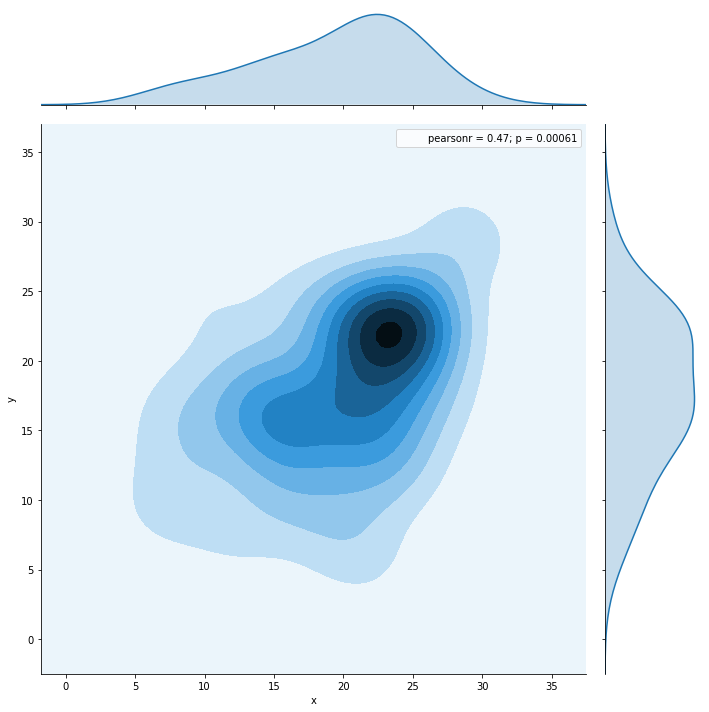

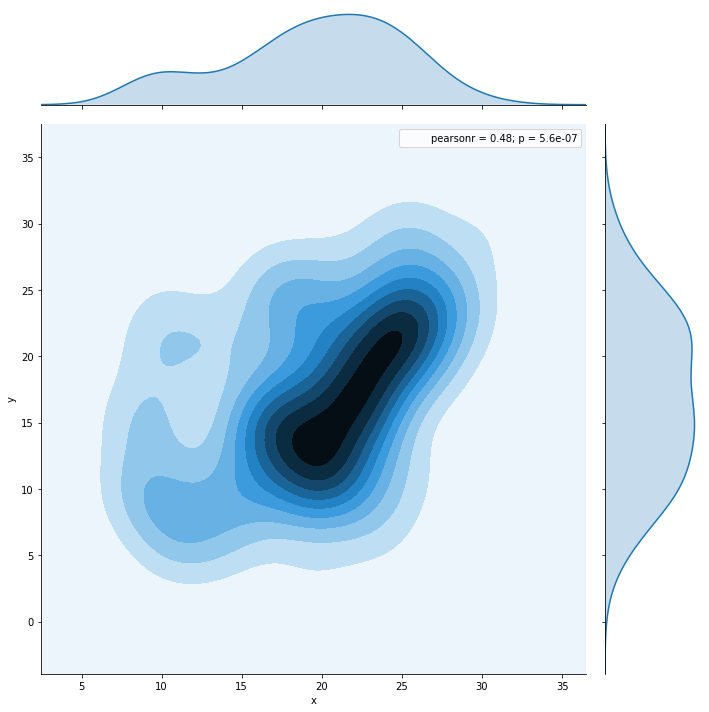

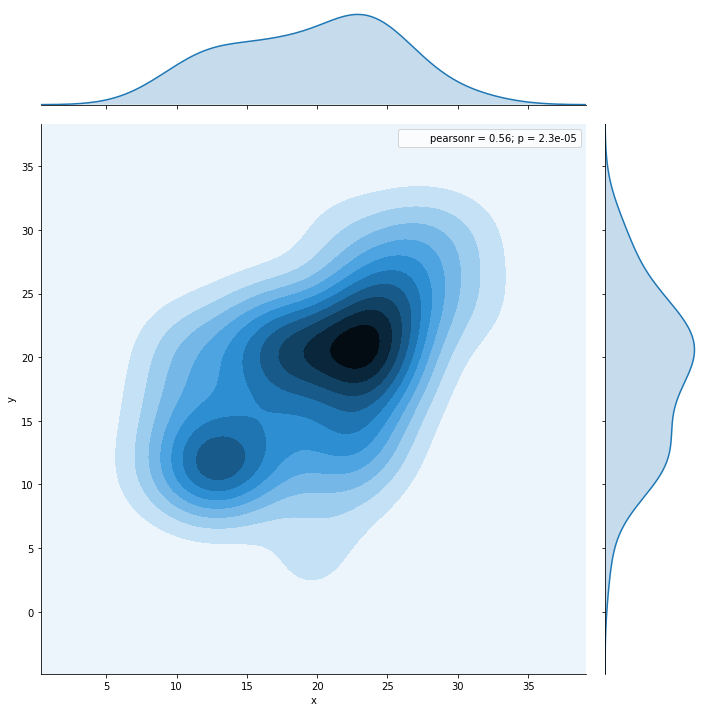

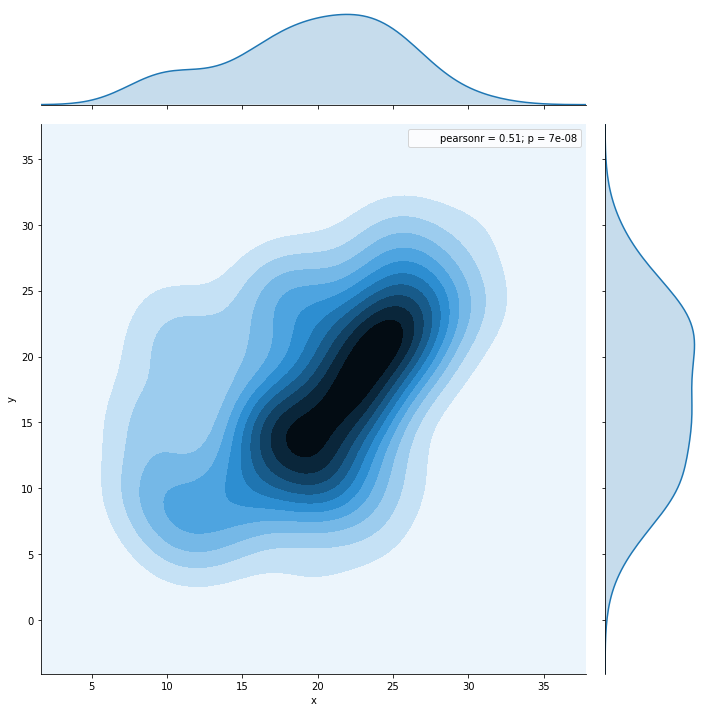

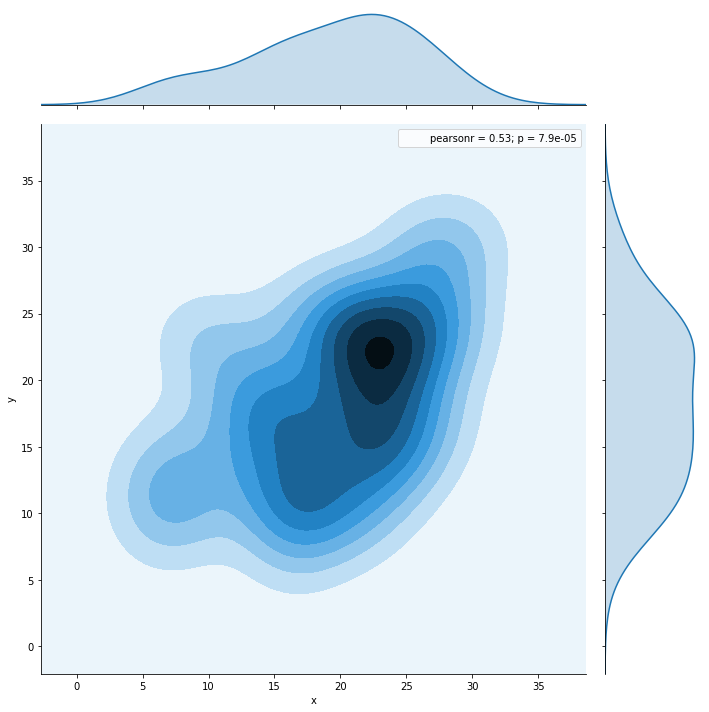

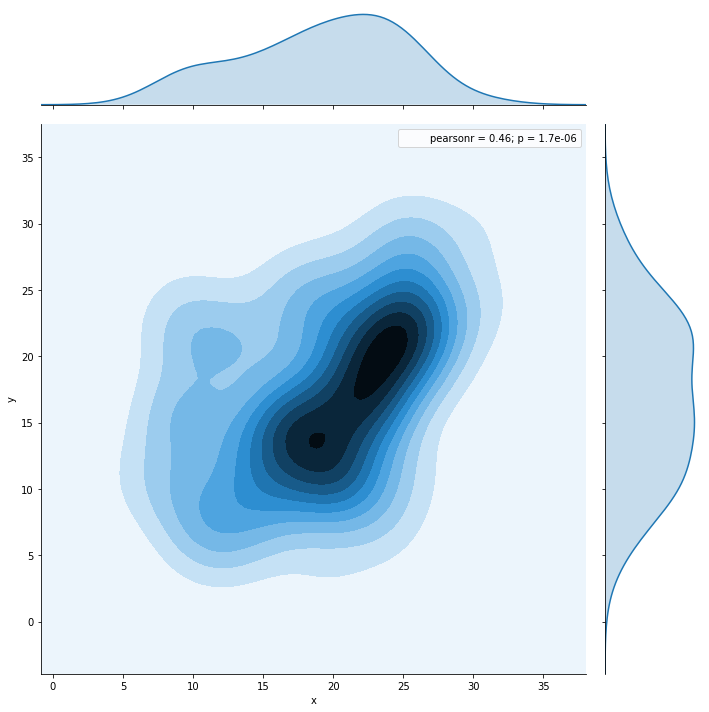

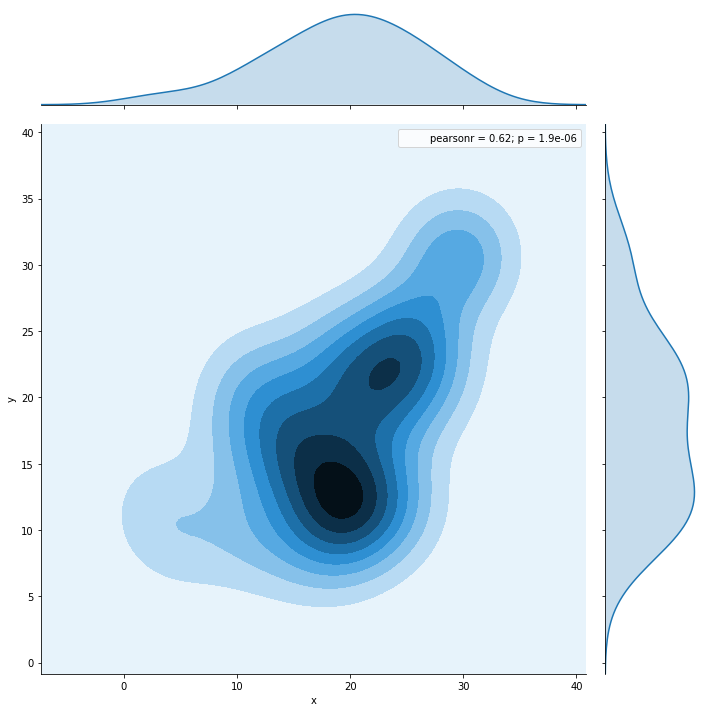

In [4]:
graph_generator()